# Power Spectral Density Method Comparison

This notebook compares two methods for computing power spectral density from RR intervals:

1. **Lomb-Scargle Periodogram**: Direct analysis of irregularly sampled RR intervals (no interpolation)
2. **Welch Method**: Analysis after cubic spline interpolation to 4 Hz uniform sampling

**Comparison metrics:**
- LF/HF ratio (0.04-0.15 Hz / 0.15-0.4 Hz)
- HF power percentage
- Spectral peak locations and magnitudes
- Overall power distribution

**Parameters to configure:**
- `PATIENT_ID`: Subject to analyze
- `SESSION_ID`: Session to analyze
- `RUN_NUMBER`: Run number to analyze
- `TIME_SEGMENT`: Time window for analysis

In [1]:
# Configuration parameters - MODIFY THESE AS NEEDED
PATIENT_ID = 'sub-001'       # Patient to analyze
SESSION_ID = 'ses-01'        # Session to analyze  
RUN_NUMBER = '04'            # Run number to analyze
TIME_SEGMENT = [0, 300]   # Time segment to visualize (25 minutes)

# Interpolation method configuration
INTERPOLATION_METHOD = 'akima'  # Options: 'cubic', 'pchip', 'akima'
# 'cubic': Cubic spline interpolation (smooth, may overshoot)
# 'pchip': Piecewise Cubic Hermite Interpolating Polynomial (shape-preserving, no overshoot)
# 'akima': Akima spline interpolation (local, avoids oscillations, good for irregular data)

# Data source configuration
DATA_ROOT = "/Volumes/Seizury/ds005873"  # Change to your data path

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import sys
import os
from pathlib import Path
import warnings
from scipy import signal, interpolate
from scipy.signal import lombscargle
from scipy.interpolate import PchipInterpolator, Akima1DInterpolator
import mne

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Add parent directory to path to import our modules
parent_dir = Path().absolute().parent
sys.path.append(str(parent_dir))

print(f"Working directory: {Path().absolute()}")
print(f"Parent directory: {parent_dir}")
print(f"Interpolation method: {INTERPOLATION_METHOD.upper()}")

# Validate interpolation method
valid_methods = ['cubic', 'pchip', 'akima']
if INTERPOLATION_METHOD.lower() not in valid_methods:
    raise ValueError(f"Invalid interpolation method '{INTERPOLATION_METHOD}'. Must be one of: {valid_methods}")

Working directory: /Users/pietrosaveri/Desktop/Pietro/•StartUps/Seizury/scr/• HRV_overlapping/plots
Parent directory: /Users/pietrosaveri/Desktop/Pietro/•StartUps/Seizury/scr/• HRV_overlapping
Interpolation method: AKIMA


In [3]:
# Import our custom modules
from data_processing_pipeline import DataDiscovery, AnnotationProcessor
from ecg_processing import ECGProcessor
from hrv_features import HRVFeatureExtractor

### Search the patient we want

In [4]:
# Initialize processing modules and load data
print("Initializing processing modules...")

# Data discovery
discovery = DataDiscovery(DATA_ROOT)
discovery.scan_dataset()
matched_runs = discovery.match_runs()

# Find target run
target_run = None
for run in matched_runs:
    if (run['subject'] == PATIENT_ID and 
        run['session'] == SESSION_ID and 
        run['run'] == RUN_NUMBER):
        target_run = run
        break

print(f"Found target run: {target_run['subject']}/{target_run['session']}/run-{target_run['run']}")

# Initialize processors
ecg_processor = ECGProcessor(sampling_rate=256)
hrv_extractor = HRVFeatureExtractor(resampling_rate=4.0)
annotation_processor = AnnotationProcessor()

print("Processing modules initialized")

Initializing processing modules...
S3 connection established successfully
Scanning dataset structure...
Found target run: sub-001/ses-01/run-04
Processing modules initialized


### Create the tagogram fusing the fucntion in ecg_processing

In [5]:
# Load and process ECG data
print(f"Processing recording: {target_run['subject']}/{target_run['session']}/run-{target_run['run']}")

# Load seizure annotations
seizure_events = pd.DataFrame()
if target_run['annotation_file']:
    seizure_events = annotation_processor.load_annotations(target_run['annotation_file'])
    print(f"Loaded {len(seizure_events)} seizure events")
    if not seizure_events.empty:
        print(f"  Seizure onsets (s): {seizure_events['onset'].tolist()}")

# Load EEG for recording duration
raw_eeg = mne.io.read_raw_edf(target_run['eeg_file'], preload=True, verbose=False)
if raw_eeg.info['sfreq'] != ecg_processor.sampling_rate:
    raw_eeg.resample(ecg_processor.sampling_rate, verbose=False)
total_duration = raw_eeg.times[-1]

# Load ECG data
raw_ecg = mne.io.read_raw_edf(target_run['ecg_file'], preload=True, verbose=False)
if raw_ecg.info['sfreq'] != ecg_processor.sampling_rate:
    raw_ecg.resample(ecg_processor.sampling_rate, verbose=False)
ecg_data = raw_ecg.get_data()[0]

# Clear raw objects
del raw_eeg, raw_ecg

# Extract tachogram
print("\nExtracting tachogram from ECG...")
tachogram_result = ecg_processor.process_ecg_to_tachogram(ecg_data)

print(f"Tachogram extraction completed:")
print(f"  Total RR intervals: {len(tachogram_result['filtered_rr'])}")
print(f"  Recording duration: {tachogram_result['filtered_times'][-1]:.1f} seconds")
print(f"  Mean RR interval: {np.mean(tachogram_result['filtered_rr']):.3f} seconds")

Processing recording: sub-001/ses-01/run-04
Loaded 0 seizure events

Extracting tachogram from ECG...
Tachogram extraction completed:
  Total RR intervals: 24969
  Recording duration: 21205.6 seconds
  Mean RR interval: 0.849 seconds


### Exract the RR intervals and times

In [6]:
# Extract time segment for analysis
rr_intervals = tachogram_result['filtered_rr']
rr_times = tachogram_result['filtered_times']

start_time, end_time = TIME_SEGMENT
segment_mask = (rr_times >= start_time) & (rr_times <= end_time)
segment_rr = rr_intervals[segment_mask]
segment_times = rr_times[segment_mask]

print(f"Time segment analysis ({start_time}-{end_time} seconds):")
print(f"  RR intervals in segment: {len(segment_rr)}")
print(f"  Segment duration: {segment_times[-1] - segment_times[0]:.1f} seconds")
print(f"  Mean RR: {np.mean(segment_rr):.3f} seconds")
print(f"  RR std: {np.std(segment_rr):.3f} seconds")
print(f"  Heart rate: {60/np.mean(segment_rr):.1f} BPM")

if len(segment_rr) < 20:
    print("Warning: Very few RR intervals. Consider adjusting TIME_SEGMENT.")
    
# Check for seizures in segment
seizures_in_segment = []
if not seizure_events.empty:
    for _, seizure in seizure_events.iterrows():
        if start_time <= seizure['onset'] <= end_time:
            seizures_in_segment.append(seizure['onset'])
            
if seizures_in_segment:
    print(f"  Seizures in segment: {seizures_in_segment}")
else:
    print("  No seizures in selected segment")

Time segment analysis (0-300 seconds):
  RR intervals in segment: 358
  Segment duration: 297.8 seconds
  Mean RR: 0.834 seconds
  RR std: 0.023 seconds
  Heart rate: 71.9 BPM
  No seizures in selected segment


### We choose the analysis parameters

In [8]:
# Frequency bands (Hz) following Task Force guidelines
vlf_band = [0.003, 0.04]
lf_band = [0.04, 0.15]
hf_band = [0.15, 0.4]

# Analysis frequency range
f_min = 0.003
f_max = 0.5
n_freq_points = 1000

### Remove the outliers using the IQR method

In [9]:
def remove_outliers_iqr(rr_intervals, rr_times):
    """
    Remove outliers from RR intervals using the Interquartile Range (IQR) method.
    Replaces outliers with appropriate quartile values instead of removing them.
    
    Args:
        rr_intervals: RR intervals in seconds
        rr_times: Times corresponding to RR intervals in seconds
        
    Returns:
        Tuple of (cleaned_rr_intervals, cleaned_rr_times, outlier_mask)
    """
    if len(rr_intervals) < 4:
        return rr_intervals, rr_times, np.ones(len(rr_intervals), dtype=bool)
    
    # Calculate quartiles
    Q1 = np.percentile(rr_intervals, 25)
    Q3 = np.percentile(rr_intervals, 75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create mask for outliers
    outlier_mask_low = rr_intervals < lower_bound
    outlier_mask_high = rr_intervals > upper_bound
    outlier_mask = outlier_mask_low | outlier_mask_high
    
    # Replace outliers with appropriate quartile values
    cleaned_rr = rr_intervals.copy()
    cleaned_rr[outlier_mask_low] = Q1  # Replace low outliers with Q1
    cleaned_rr[outlier_mask_high] = Q3  # Replace high outliers with Q3
    
    # Recalculate timeline based on corrected RR intervals
    # Timeline should reflect cumulative sum of RR intervals
    cleaned_times = np.zeros_like(rr_times)
    cleaned_times[0] = rr_times[0]  # Keep the same starting time
    
    # Calculate cumulative sum of corrected RR intervals for proper timeline
    for i in range(1, len(cleaned_rr)):
        cleaned_times[i] = cleaned_times[i-1] + cleaned_rr[i-1]
    
    # Calculate timeline adjustment statistics
    original_duration = rr_times[-1] - rr_times[0]
    corrected_duration = cleaned_times[-1] - cleaned_times[0]
    timeline_change = corrected_duration - original_duration
    
    n_outliers = np.sum(outlier_mask)
    n_low_outliers = np.sum(outlier_mask_low)
    n_high_outliers = np.sum(outlier_mask_high)
    outlier_percentage = (n_outliers / len(rr_intervals)) * 100
    
    print(f"  Outlier handling (IQR method):")
    print(f"    Q1: {Q1*1000:.1f} ms, Q3: {Q3*1000:.1f} ms, IQR: {IQR*1000:.1f} ms")
    print(f"    Bounds: [{lower_bound*1000:.1f}, {upper_bound*1000:.1f}] ms")
    print(f"    Found {n_outliers} outliers ({outlier_percentage:.1f}%)")
    print(f"      - {n_low_outliers} low outliers (< {lower_bound*1000:.1f} ms) → replaced with Q1")
    print(f"      - {n_high_outliers} high outliers (> {upper_bound*1000:.1f} ms) → replaced with Q3")
    print(f"    Timeline adjustment:")
    print(f"      - Original duration: {original_duration:.1f} seconds")
    print(f"      - Corrected duration: {corrected_duration:.1f} seconds")
    print(f"      - Timeline change: {timeline_change:+.1f} seconds")
    print(f"    Kept all {len(cleaned_rr)} RR intervals with outlier correction and timeline adjustment")
    
    return cleaned_rr, cleaned_times, ~outlier_mask  # Return non-outlier mask

### Merge the RR Intervals using the treshold

In [10]:
def merge_short_rr_intervals(rr_intervals, rr_times, threshold_ms=250):
    """
    Merge RR intervals that are <= threshold_ms with the adjacent shortest RR interval.
    
    Args:
        rr_intervals: RR intervals in seconds
        rr_times: Times corresponding to RR intervals in seconds
        threshold_ms: Threshold in milliseconds (default: 250ms)
        
    Returns:
        Tuple of (merged_rr_intervals, merged_rr_times, merge_info)
    """
    if len(rr_intervals) < 2:
        return rr_intervals, rr_times, {'n_merged': 0}
    
    threshold_s = threshold_ms / 1000.0  # Convert to seconds
    merged_rr = rr_intervals.copy()
    merged_times = rr_times.copy()
    n_merged = 0
    
    i = 0
    while i < len(merged_rr):
        if merged_rr[i] <= threshold_s:
            # Find the adjacent RR interval to merge with (choose the shortest)
            left_idx = i - 1 if i > 0 else None
            right_idx = i + 1 if i < len(merged_rr) - 1 else None
            
            if left_idx is not None and right_idx is not None:
                # Both neighbors exist, choose the shortest
                if merged_rr[left_idx] <= merged_rr[right_idx]:
                    merge_idx = left_idx
                else:
                    merge_idx = right_idx
            elif left_idx is not None:
                # Only left neighbor exists
                merge_idx = left_idx
            elif right_idx is not None:
                # Only right neighbor exists
                merge_idx = right_idx
            else:
                # No neighbors (shouldn't happen with len >= 2)
                i += 1
                continue
            
            # Merge the intervals
            merged_rr[merge_idx] = merged_rr[merge_idx] + merged_rr[i]
            
            # Remove the short interval
            merged_rr = np.delete(merged_rr, i)
            merged_times = np.delete(merged_times, i)
            
            n_merged += 1
            
            # Don't increment i since we removed an element
            if merge_idx > i:
                # If we merged with right neighbor, continue from same position
                continue
            else:
                # If we merged with left neighbor, we need to adjust position
                i = max(0, i - 1)
        else:
            i += 1
    
    # Recalculate timeline based on merged RR intervals if any merging occurred
    if n_merged > 0:
        # Recalculate timeline to reflect the merged intervals
        corrected_merged_times = np.zeros_like(merged_times)
        corrected_merged_times[0] = merged_times[0]  # Keep the same starting time
        
        # Calculate cumulative sum of merged RR intervals for proper timeline
        for i in range(1, len(merged_rr)):
            corrected_merged_times[i] = corrected_merged_times[i-1] + merged_rr[i-1]
        
        merged_times = corrected_merged_times
        
        # Calculate timeline adjustment statistics
        original_duration = rr_times[-1] - rr_times[0]
        merged_duration = merged_times[-1] - merged_times[0]
        timeline_change = merged_duration - original_duration
    
    merge_info = {
        'n_merged': n_merged,
        'threshold_ms': threshold_ms,
        'original_count': len(rr_intervals),
        'final_count': len(merged_rr)
    }
    
    if n_merged > 0:
        merge_percentage = (n_merged / len(rr_intervals)) * 100
        print(f"  Short RR interval merging (≤{threshold_ms} ms):")
        print(f"    Found {n_merged} short intervals ({merge_percentage:.1f}%)")
        print(f"    Merged with adjacent shortest intervals")
        print(f"    RR count: {len(rr_intervals)} → {len(merged_rr)}")
        print(f"    Timeline adjustment:")
        print(f"      - Original duration: {original_duration:.1f} seconds")
        print(f"      - Merged duration: {merged_duration:.1f} seconds")
        print(f"      - Timeline change: {timeline_change:+.1f} seconds")
    else:
        print(f"  Short RR interval check: No intervals ≤{threshold_ms} ms found")
    
    return merged_rr, merged_times, merge_info

### Preproess RR Intervals

In [11]:
def preprocess_rr_intervals(rr_intervals, rr_times):
    """
    Comprehensive preprocessing of RR intervals for spectral analysis.
    
    Steps:
    1. Merge short RR intervals (≤250ms) with adjacent shortest intervals
    2. Remove outliers (IQR method - replace with quartiles)
    3. Remove mean (center the data) - recalculate timeline
    4. High-pass filter detrend (remove frequencies < 0.003 Hz)
    
    Timeline is recalculated after each step that modifies RR interval durations
    to maintain temporal consistency for accurate spectral analysis.
    
    Args:
        rr_intervals: RR intervals in seconds
        rr_times: Times corresponding to RR intervals in seconds
        
    Returns:
        Tuple of (processed_rr, processed_times, preprocessing_info)
    """
    # Step 1: Merge short RR intervals before outlier detection
    merged_rr, merged_times, merge_info = merge_short_rr_intervals(rr_intervals, rr_times)
    
    # Step 2: Handle outliers by replacing with quartiles
    clean_rr, clean_times, non_outlier_mask = remove_outliers_iqr(merged_rr, merged_times)
    
    if len(clean_rr) < 4:
        print("  Warning: Too few RR intervals after outlier handling")
        return np.array([]), np.array([]), {}
    
    # Step 3: Remove mean (centering)
    original_mean = np.mean(clean_rr)
    centered_rr = clean_rr - original_mean
    
    # Recalculate timeline after mean removal (important for temporal consistency)
    # Timeline should reflect the actual RR interval durations
    centered_times = np.zeros_like(clean_times)
    centered_times[0] = clean_times[0]  # Keep the same starting time
    
    # Calculate cumulative sum of centered RR intervals for proper timeline
    # Note: we need to add back the mean for timeline calculation since timeline is cumulative
    rr_for_timeline = centered_rr + original_mean  # Restore original durations for timeline
    for i in range(1, len(centered_rr)):
        centered_times[i] = centered_times[i-1] + rr_for_timeline[i-1]
    
    # Calculate timeline statistics after mean removal
    pre_mean_duration = clean_times[-1] - clean_times[0]
    post_mean_duration = centered_times[-1] - centered_times[0]
    mean_timeline_change = post_mean_duration - pre_mean_duration
    
    print(f"  Mean removal:")
    print(f"    Original mean: {original_mean*1000:.1f} ms")
    print(f"    Data centered around zero")
    print(f"    Timeline recalculation:")
    print(f"      - Duration before: {pre_mean_duration:.1f} seconds")
    print(f"      - Duration after: {post_mean_duration:.1f} seconds")
    print(f"      - Timeline change: {mean_timeline_change:+.3f} seconds (should be ~0)")
    
    # Step 4: High-pass filter detrending (remove frequencies < 0.003 Hz)
    from scipy import signal as scipy_signal
    
    # First interpolate to uniform sampling for filtering
    # Calculate appropriate sampling rate from data
    time_span = centered_times[-1] - centered_times[0]
    n_samples = len(centered_times)
    original_fs = n_samples / time_span
    
    # Use at least 4 Hz for proper filtering, but adapt to data
    target_fs = max(4.0, original_fs * 2)  # Ensure Nyquist criterion
    
    # Create uniform time grid for filtering
    uniform_times_filter = np.linspace(centered_times[0], centered_times[-1], 
                                     int(time_span * target_fs))
    
    # Interpolate data to uniform grid
    interp_for_filter = np.interp(uniform_times_filter, centered_times, centered_rr)
    
    # Design high-pass filter to remove frequencies < 0.003 Hz
    cutoff_freq = 0.04  # Hz - FIXED to 0.003 as requested
    nyquist_freq = target_fs / 2
    normalized_cutoff = cutoff_freq / nyquist_freq
    
    # Ensure normalized frequency is valid
    if normalized_cutoff >= 1.0:
        print(f"    Warning: Cutoff frequency {cutoff_freq} Hz too high for sampling rate {target_fs} Hz")
        print(f"    Using linear detrending instead")
        detrended_rr = scipy_signal.detrend(centered_rr, type='linear')
        trend_method = "linear (fallback)"
    else:
        # Design Butterworth high-pass filter
        try:
            sos = scipy_signal.butter(4, normalized_cutoff, btype='high', output='sos')
            
            # Apply zero-phase filtering to avoid phase distortion
            filtered_uniform = scipy_signal.sosfiltfilt(sos, interp_for_filter)
            
            # Interpolate back to original time points
            detrended_rr = np.interp(centered_times, uniform_times_filter, filtered_uniform)
            trend_method = f"high-pass filter (cutoff: {cutoff_freq} Hz)"
            
            print(f"  High-pass filter detrending:")
            print(f"    Cutoff frequency: {cutoff_freq} Hz")
            print(f"    Filter order: 4th order Butterworth")
            print(f"    Sampling rate for filtering: {target_fs:.1f} Hz")
            print(f"    Normalized cutoff: {normalized_cutoff:.3f}")
            
        except Exception as e:
            print(f"    Warning: High-pass filtering failed: {e}")
            print(f"    Using linear detrending instead")
            detrended_rr = scipy_signal.detrend(centered_rr, type='linear')
            trend_method = "linear (fallback)"
    
    # Calculate the amount of trend/drift removed
    trend_removed = np.std(centered_rr) - np.std(detrended_rr)
    
    print(f"    Method used: {trend_method}")
    print(f"    Variance removed: {trend_removed*1000:.1f} ms² (low-frequency components)")
    
    # Preprocessing summary
    preprocessing_info = {
        'n_merged': merge_info['n_merged'],
        'merge_percentage': merge_info['n_merged'] / len(rr_intervals) * 100,
        'n_outliers_replaced': np.sum(~non_outlier_mask),
        'outlier_percentage': np.sum(~non_outlier_mask) / len(merged_rr) * 100,
        'original_mean': original_mean,
        'detrend_method': trend_method,
        'cutoff_frequency': cutoff_freq,
        'final_mean': np.mean(detrended_rr),
        'final_std': np.std(detrended_rr),
        'trend_removed_variance': trend_removed
    }
    
    print(f"  Final preprocessed data:")
    print(f"    Mean: {preprocessing_info['final_mean']*1000:.3f} ms (should be ~0)")
    print(f"    Std: {preprocessing_info['final_std']*1000:.1f} ms")
    print(f"    Total intervals: {len(rr_intervals)} → {len(detrended_rr)}")
    
    return detrended_rr, centered_times, preprocessing_info

### Lomb-Scargle Periodogram (No Interpolation)

In [12]:
# Method 1: Lomb-Scargle Periodogram (No Interpolation)
print("\nMethod 1: Lomb-Scargle Periodogram (Direct analysis, no interpolation)")

def compute_lombscargle_psd(rr_intervals, rr_times, f_min=0.003, f_max=0.5, n_points=1000):
    """
    Compute Lomb-Scargle periodogram from preprocessed RR intervals with proper normalization.
    
    This method applies comprehensive preprocessing (outlier handling, mean removal, detrending)
    before computing the periodogram, preserving the original timing of heartbeats.
    """
    # Apply comprehensive preprocessing
    processed_rr, processed_times, preproc_info = preprocess_rr_intervals(rr_intervals, rr_times)
    
    if len(processed_rr) < 4:
        print("  Warning: Too few RR intervals after preprocessing")
        return np.array([]), np.array([])
    
    # Create frequency array
    freqs = np.linspace(f_min, f_max, n_points)
    
    # Compute Lomb-Scargle periodogram on preprocessed data
    # Using angular frequencies for scipy.signal.lombscargle
    omega = 2 * np.pi * freqs
    N = len(processed_times)
    
    # Calculate the periodogram using normalize=False to get raw power values
    psd_ls = lombscargle(processed_times, processed_rr, omega, normalize=False)
    
    # Apply proper normalization for power spectral density
    # Standard normalization for Lomb-Scargle periodogram
    # Factor of 2 accounts for single-sided spectrum (positive frequencies only)
    # Division by N accounts for the number of data points
    # Frequency resolution normalization
    df = freqs[1] - freqs[0]  # Frequency resolution
    
    # Normalize to get proper power spectral density units
    # This ensures the PSD has units of (signal units)²/Hz
    psd_ls = psd_ls * 2.0 / (N * df)
    
    # Additional normalization to account for the variance of the signal
    # This makes the total power equal to the signal variance
    signal_variance = np.var(processed_rr)
    total_periodogram_power = np.sum(psd_ls) * df
    
    if total_periodogram_power > 0:
        # Scale to preserve signal power
        normalization_factor = signal_variance / total_periodogram_power
        psd_ls = psd_ls * normalization_factor
        
        print(f"  Lomb-Scargle normalization:")
        print(f"    Signal variance: {signal_variance*1e6:.2f} ms²")
        print(f"    Raw periodogram power: {total_periodogram_power*1e6:.2f} ms²")
        print(f"    Normalization factor: {normalization_factor:.4f}")
        print(f"    Final PSD power: {(np.sum(psd_ls) * df)*1e6:.2f} ms²")
    else:
        print(f"  Warning: Zero periodogram power, normalization skipped")
    
    return freqs, psd_ls

# Apply preprocessing and compute Lomb-Scargle PSD
print(f"Original segment: {len(segment_rr)} RR intervals")
freqs_ls, psd_ls = compute_lombscargle_psd(segment_rr, segment_times, f_min, f_max, n_freq_points)

print(f"Lomb-Scargle analysis completed:")
print(f"  Frequency points: {len(freqs_ls)}")
if len(psd_ls) > 0:
    print(f"  PSD range: {np.min(psd_ls):.6f} - {np.max(psd_ls):.6f}")
    print(f"  PSD normalization: Power-preserving with variance matching")
else:
    print("  Warning: No PSD computed due to insufficient data")


Method 1: Lomb-Scargle Periodogram (Direct analysis, no interpolation)
Original segment: 358 RR intervals
  Short RR interval check: No intervals ≤250 ms found
  Outlier handling (IQR method):
    Q1: 820.3 ms, Q3: 851.6 ms, IQR: 31.2 ms
    Bounds: [773.4, 898.4] ms
    Found 0 outliers (0.0%)
      - 0 low outliers (< 773.4 ms) → replaced with Q1
      - 0 high outliers (> 898.4 ms) → replaced with Q3
    Timeline adjustment:
      - Original duration: 297.8 seconds
      - Corrected duration: 297.9 seconds
      - Timeline change: +0.1 seconds
    Kept all 358 RR intervals with outlier correction and timeline adjustment
  Mean removal:
    Original mean: 834.2 ms
    Data centered around zero
    Timeline recalculation:
      - Duration before: 297.9 seconds
      - Duration after: 297.9 seconds
      - Timeline change: +0.000 seconds (should be ~0)
  High-pass filter detrending:
    Cutoff frequency: 0.04 Hz
    Filter order: 4th order Butterworth
    Sampling rate for filtering: 

### Welch Method with Interpolation

In [13]:
# Method 2: Welch Method with Interpolation
print(f"\nMethod 2: Welch Method (After {INTERPOLATION_METHOD.upper()} interpolation to 4 Hz)")

def interpolate_rr_intervals_configurable(rr_intervals, rr_times, method='cubic', sampling_rate=4.0):
    """
    Interpolate RR intervals using cubic spline, PCHIP, or Akima method with comprehensive preprocessing.
    
    Args:
        rr_intervals: RR intervals in seconds
        rr_times: Times corresponding to RR intervals in seconds
        method: 'cubic', 'pchip', or 'akima'
        sampling_rate: Target sampling rate in Hz
        
    Returns:
        Tuple of (interpolated_rr, uniform_times)
    """
    # Apply comprehensive preprocessing (same as Lomb-Scargle)
    processed_rr, processed_times, preproc_info = preprocess_rr_intervals(rr_intervals, rr_times)
    
    # Handle empty or insufficient input after preprocessing
    if len(processed_rr) == 0 or len(processed_times) == 0:
        return np.array([]), np.array([])
        
    if len(processed_rr) < 2 or len(processed_times) < 2:
        return np.array([]), np.array([])
    
    # Create uniform time vector at resampling rate
    start_time = processed_times[0]
    end_time = processed_times[-1]
    time_span = end_time - start_time
    
    if time_span <= 0:
        return np.array([]), np.array([])
        
    uniform_times = np.arange(start_time, end_time, 1/sampling_rate)
    
    if len(uniform_times) < 2:
        return np.array([]), np.array([])
    
    try:
        if method.lower() == 'pchip':
            # PCHIP: Piecewise Cubic Hermite Interpolating Polynomial
            # Shape-preserving, no overshoot, monotonicity-preserving
            interp_func = PchipInterpolator(processed_times, processed_rr, extrapolate=True)
            interpolated_rr = interp_func(uniform_times)
            
        elif method.lower() == 'akima':
            # Akima: Akima spline interpolation
            # Local interpolation, avoids oscillations, good for irregular data
            interp_func = Akima1DInterpolator(processed_times, processed_rr)
            interpolated_rr = interp_func(uniform_times, extrapolate=True)
            
        elif method.lower() == 'cubic':
            # Cubic spline interpolation
            interp_func = interpolate.interp1d(processed_times, processed_rr, 
                                             kind='cubic', 
                                             bounds_error=False,
                                             fill_value='extrapolate')
            interpolated_rr = interp_func(uniform_times)
        else:
            raise ValueError(f"Unknown interpolation method: {method}")
        
        # Remove any invalid values
        valid_mask = np.isfinite(interpolated_rr)
        if not np.any(valid_mask):
            return np.array([]), np.array([])
            
        return interpolated_rr[valid_mask], uniform_times[valid_mask]
        
    except Exception as e:
        print(f"Warning: RR interval interpolation failed: {e}")
        return np.array([]), np.array([])

def compute_welch_psd_interpolated(rr_intervals, rr_times, method='cubic', sampling_rate=4.0):
    """
    Compute Welch PSD after comprehensive preprocessing and interpolation to uniform sampling.
    
    This method applies:
    1. Outlier removal (IQR method)
    2. Mean removal (centering)
    3. Linear detrending
    4. Interpolation to uniform sampling
    5. Welch's method for PSD estimation
    
    Args:
        rr_intervals: RR intervals in seconds
        rr_times: Times corresponding to RR intervals in seconds
        method: Interpolation method ('cubic', 'pchip', or 'akima')
        sampling_rate: Target sampling rate in Hz
    """
    # Interpolate to uniform sampling using configurable method (includes preprocessing)
    interpolated_rr, interpolated_times = interpolate_rr_intervals_configurable(
        rr_intervals, rr_times, method, sampling_rate)
    
    if len(interpolated_rr) < 10:
        print(f"Warning: {method.upper()} interpolation produced very few points")
        return np.array([]), np.array([]), np.array([]), np.array([])
    
    # Additional detrending can be applied in Welch's method
    # The 'constant' detrend removes any remaining DC component
    # The 'linear' detrend removes linear trends (redundant after preprocessing, but ensures clean data)
    detrend_method = None  # Options: 'constant', 'linear', None
    
    # Compute Welch PSD on interpolated data
    freqs_welch, psd_welch = signal.welch(
        interpolated_rr,
        fs=sampling_rate,
        nperseg=512, #2048 for 25 min
        noverlap=384, #1536 for 25 min
        window='hann',
        detrend=detrend_method, # Additional detrending in Welch
        scaling='density',
        return_onesided = True
    )
    
    print(f"  Welch PSD computation:")
    print(f"    Window function: Hann")
    print(f"    Segment length (nperseg): 256")
    print(f"    Detrending in Welch: {detrend_method}")
    print(f"    Overlap: 50% (default)")
    
    return freqs_welch, psd_welch, interpolated_rr, interpolated_times

# Compute Welch PSD with configurable interpolation method
print(f"Original segment: {len(segment_rr)} RR intervals")
freqs_welch, psd_welch, interpolated_rr, interpolated_times = compute_welch_psd_interpolated(
    segment_rr, segment_times, INTERPOLATION_METHOD, hrv_extractor.resampling_rate
)

print(f"Welch analysis with {INTERPOLATION_METHOD.upper()} interpolation completed:")
print(f"  Original RR points: {len(segment_rr)}")
print(f"  Interpolated points: {len(interpolated_rr)}")
print(f"  Frequency points: {len(freqs_welch)}")
if len(interpolated_rr) > 0:
    print(f"  Sampling rate: {len(interpolated_rr)/(interpolated_times[-1]-interpolated_times[0]):.2f} Hz")
    print(f"  PSD range: {np.min(psd_welch):.6f} - {np.max(psd_welch):.6f}")


# Analyze interpolation quality
if len(interpolated_rr) > 0:
    # Get preprocessed data for fair comparison
    processed_segment_rr, processed_segment_times, preproc_info = preprocess_rr_intervals(segment_rr, segment_times)
    
    if len(processed_segment_rr) > 0:
        rr_mean_preservation = np.mean(interpolated_rr) / np.mean(processed_segment_rr) if np.mean(processed_segment_rr) != 0 else 1.0
        rr_std_preservation = np.std(interpolated_rr) / np.std(processed_segment_rr) * 100
        
        print(f"\nInterpolation Quality Metrics (after preprocessing):")
        print(f"  Mean preservation: {rr_mean_preservation:.3f} (should be ~1 for centered data)")
        print(f"  Std preservation: {rr_std_preservation:.1f}%")
        print(f"  Interpolation ratio: {len(interpolated_rr)/len(processed_segment_rr):.1f}x")
        
        # Check for overshoot (values outside original range)
        original_min, original_max = np.min(processed_segment_rr), np.max(processed_segment_rr)
        interpolated_min, interpolated_max = np.min(interpolated_rr), np.max(interpolated_rr)
        overshoot_low = original_min - interpolated_min if interpolated_min < original_min else 0
        overshoot_high = interpolated_max - original_max if interpolated_max > original_max else 0
        
        print(f"  Overshoot below min: {overshoot_low*1000:.1f} ms")
        print(f"  Overshoot above max: {overshoot_high*1000:.1f} ms")
        
        if overshoot_low > 0 or overshoot_high > 0:
            overshoot_severity = "MILD" if (overshoot_low + overshoot_high) < 0.05 else "MODERATE" if (overshoot_low + overshoot_high) < 0.1 else "SEVERE"
            print(f"  -> {INTERPOLATION_METHOD.upper()} shows {overshoot_severity} overshoot")
        else:
            print(f"  -> {INTERPOLATION_METHOD.upper()} preserves original range perfectly")
            
        # Calculate local smoothness (measure of oscillations)
        if len(interpolated_rr) > 4:
            # Second derivative as smoothness measure
            interp_diff2 = np.diff(interpolated_rr, n=2)
            smoothness_metric = np.std(interp_diff2) / np.std(interpolated_rr) * 1000 if np.std(interpolated_rr) > 0 else 0
            print(f"  Local smoothness: {smoothness_metric:.2f} (lower = smoother)")
            
            # Oscillation detection (sign changes in first derivative)
            interp_diff1 = np.diff(interpolated_rr)
            sign_changes = np.sum(np.diff(np.sign(interp_diff1)) != 0)
            oscillation_ratio = sign_changes / len(interp_diff1) * 100
            print(f"  Oscillation tendency: {oscillation_ratio:.1f}% (sign changes in derivative)")

print(f"\nPreprocessing Pipeline Summary:")
print("  ✓ Step 1: Short RR interval merging (≤250ms physiological correction)")
print("  ✓ Step 2: IQR outlier removal (physiological filtering)")
print("  ✓ Step 3: Mean removal (data centering)")
print("  ✓ Step 4: Linear detrending (removes drift)")
print("  ✓ Step 5: Interpolation (uniform sampling for Welch)")
print("  ✓ Step 6: Additional detrending in Welch (removes residual DC)")


Method 2: Welch Method (After AKIMA interpolation to 4 Hz)
Original segment: 358 RR intervals
  Short RR interval check: No intervals ≤250 ms found
  Outlier handling (IQR method):
    Q1: 820.3 ms, Q3: 851.6 ms, IQR: 31.2 ms
    Bounds: [773.4, 898.4] ms
    Found 0 outliers (0.0%)
      - 0 low outliers (< 773.4 ms) → replaced with Q1
      - 0 high outliers (> 898.4 ms) → replaced with Q3
    Timeline adjustment:
      - Original duration: 297.8 seconds
      - Corrected duration: 297.9 seconds
      - Timeline change: +0.1 seconds
    Kept all 358 RR intervals with outlier correction and timeline adjustment
  Mean removal:
    Original mean: 834.2 ms
    Data centered around zero
    Timeline recalculation:
      - Duration before: 297.9 seconds
      - Duration after: 297.9 seconds
      - Timeline change: +0.000 seconds (should be ~0)
  High-pass filter detrending:
    Cutoff frequency: 0.04 Hz
    Filter order: 4th order Butterworth
    Sampling rate for filtering: 4.0 Hz
    N

### Compute power in frequency bands for both methods

In [16]:
# Compute power in frequency bands for both methods
print("\nComputing power in frequency bands...")

def compute_band_power(psd, freqs, band):
    """Compute power in a specific frequency band using trapezoidal integration."""
    mask = (freqs >= band[0]) & (freqs <= band[1])
    if not np.any(mask):
        return 0.0
    
    band_psd = psd[mask]
    band_freqs = freqs[mask]
    
    if len(band_freqs) < 2:
        return 0.0
    
    power = np.trapz(band_psd, band_freqs)
    return max(0.0, power)

# Lomb-Scargle power computation
vlf_power_ls = compute_band_power(psd_ls, freqs_ls, vlf_band)
lf_power_ls = compute_band_power(psd_ls, freqs_ls, lf_band)
hf_power_ls = compute_band_power(psd_ls, freqs_ls, hf_band)
total_power_ls = vlf_power_ls + lf_power_ls + hf_power_ls

# Convert to ms² units (scale factor)
scale_factor = 1e6
vlf_power_ls *= scale_factor
lf_power_ls *= scale_factor
hf_power_ls *= scale_factor
total_power_ls *= scale_factor

# Welch power computation
vlf_power_welch = compute_band_power(psd_welch, freqs_welch, vlf_band)
lf_power_welch = compute_band_power(psd_welch, freqs_welch, lf_band)
hf_power_welch = compute_band_power(psd_welch, freqs_welch, hf_band)
total_power_welch = vlf_power_welch + lf_power_welch + hf_power_welch

# Convert to ms² units
vlf_power_welch *= scale_factor
lf_power_welch *= scale_factor
hf_power_welch *= scale_factor
total_power_welch *= scale_factor

print(f"\nLomb-Scargle Results:")
print(f"  VLF Power: {vlf_power_ls:.2f} ms²")
print(f"  LF Power:  {lf_power_ls:.2f} ms²")
print(f"  HF Power:  {hf_power_ls:.2f} ms²")
print(f"  Total:     {total_power_ls:.2f} ms²")
if hf_power_ls > 0:
    print(f"  LF/HF:     {lf_power_ls/hf_power_ls:.3f}")
    print(f"  HF%:       {hf_power_ls/total_power_ls*100:.1f}%")

print(f"\nWelch Results:")
print(f"  VLF Power: {vlf_power_welch:.2f} ms²")
print(f"  LF Power:  {lf_power_welch:.2f} ms²")
print(f"  HF Power:  {hf_power_welch:.2f} ms²")
print(f"  Total:     {total_power_welch:.2f} ms²")
if hf_power_welch > 0:
    print(f"  LF/HF:     {lf_power_welch/hf_power_welch:.3f}")
    print(f"  HF%:       {hf_power_welch/total_power_welch*100:.1f}%")


Computing power in frequency bands...

Lomb-Scargle Results:
  VLF Power: 2.72 ms²
  LF Power:  164.47 ms²
  HF Power:  124.29 ms²
  Total:     291.47 ms²
  LF/HF:     1.323
  HF%:       42.6%

Welch Results:
  VLF Power: 1.71 ms²
  LF Power:  162.58 ms²
  HF Power:  102.47 ms²
  Total:     266.76 ms²
  LF/HF:     1.587
  HF%:       38.4%


### Find spectral peaks for both methods

In [17]:
# Find spectral peaks for both methods
print("\nAnalyzing spectral peaks...")

def find_spectral_peaks(psd, freqs, height_threshold=0.1):
    """Find peaks in power spectral density."""
    from scipy.signal import find_peaks
    
    # Normalize PSD for peak finding
    psd_norm = psd / np.max(psd)
    
    # Find peaks
    peaks, properties = find_peaks(psd_norm, height=height_threshold, distance=10)
    
    peak_freqs = freqs[peaks]
    peak_powers = psd[peaks]
    
    return peak_freqs, peak_powers, peaks

# Find peaks in both PSDs
peak_freqs_ls, peak_powers_ls, peak_indices_ls = find_spectral_peaks(psd_ls, freqs_ls)
peak_freqs_welch, peak_powers_welch, peak_indices_welch = find_spectral_peaks(psd_welch, freqs_welch)

print(f"Lomb-Scargle peaks:")
for i, (freq, power) in enumerate(zip(peak_freqs_ls, peak_powers_ls)):
    band = 'VLF' if freq < 0.04 else ('LF' if freq < 0.15 else 'HF')
    print(f"  Peak {i+1}: {freq:.3f} Hz, Power: {power:.6f} ({band})")

print(f"\nWelch peaks:")
for i, (freq, power) in enumerate(zip(peak_freqs_welch, peak_powers_welch)):
    band = 'VLF' if freq < 0.04 else ('LF' if freq < 0.15 else 'HF')
    print(f"  Peak {i+1}: {freq:.3f} Hz, Power: {power:.6f} ({band})")


Analyzing spectral peaks...
Lomb-Scargle peaks:
  Peak 1: 0.052 Hz, Power: 0.003550 (LF)
  Peak 2: 0.060 Hz, Power: 0.004478 (LF)
  Peak 3: 0.069 Hz, Power: 0.006898 (LF)
  Peak 4: 0.077 Hz, Power: 0.008085 (LF)
  Peak 5: 0.082 Hz, Power: 0.003718 (LF)
  Peak 6: 0.091 Hz, Power: 0.006324 (LF)
  Peak 7: 0.103 Hz, Power: 0.001114 (LF)
  Peak 8: 0.113 Hz, Power: 0.001521 (LF)
  Peak 9: 0.125 Hz, Power: 0.001193 (LF)
  Peak 10: 0.133 Hz, Power: 0.001427 (LF)
  Peak 11: 0.149 Hz, Power: 0.001706 (LF)
  Peak 12: 0.161 Hz, Power: 0.001166 (HF)
  Peak 13: 0.168 Hz, Power: 0.001313 (HF)
  Peak 14: 0.182 Hz, Power: 0.002359 (HF)
  Peak 15: 0.202 Hz, Power: 0.001114 (HF)
  Peak 16: 0.210 Hz, Power: 0.001148 (HF)
  Peak 17: 0.226 Hz, Power: 0.001108 (HF)
  Peak 18: 0.256 Hz, Power: 0.001081 (HF)
  Peak 19: 0.265 Hz, Power: 0.001888 (HF)
  Peak 20: 0.273 Hz, Power: 0.003182 (HF)
  Peak 21: 0.280 Hz, Power: 0.001646 (HF)
  Peak 22: 0.294 Hz, Power: 0.002991 (HF)
  Peak 23: 0.319 Hz, Power: 0.001967

# PLOTTING


Creating comprehensive comparison visualization...


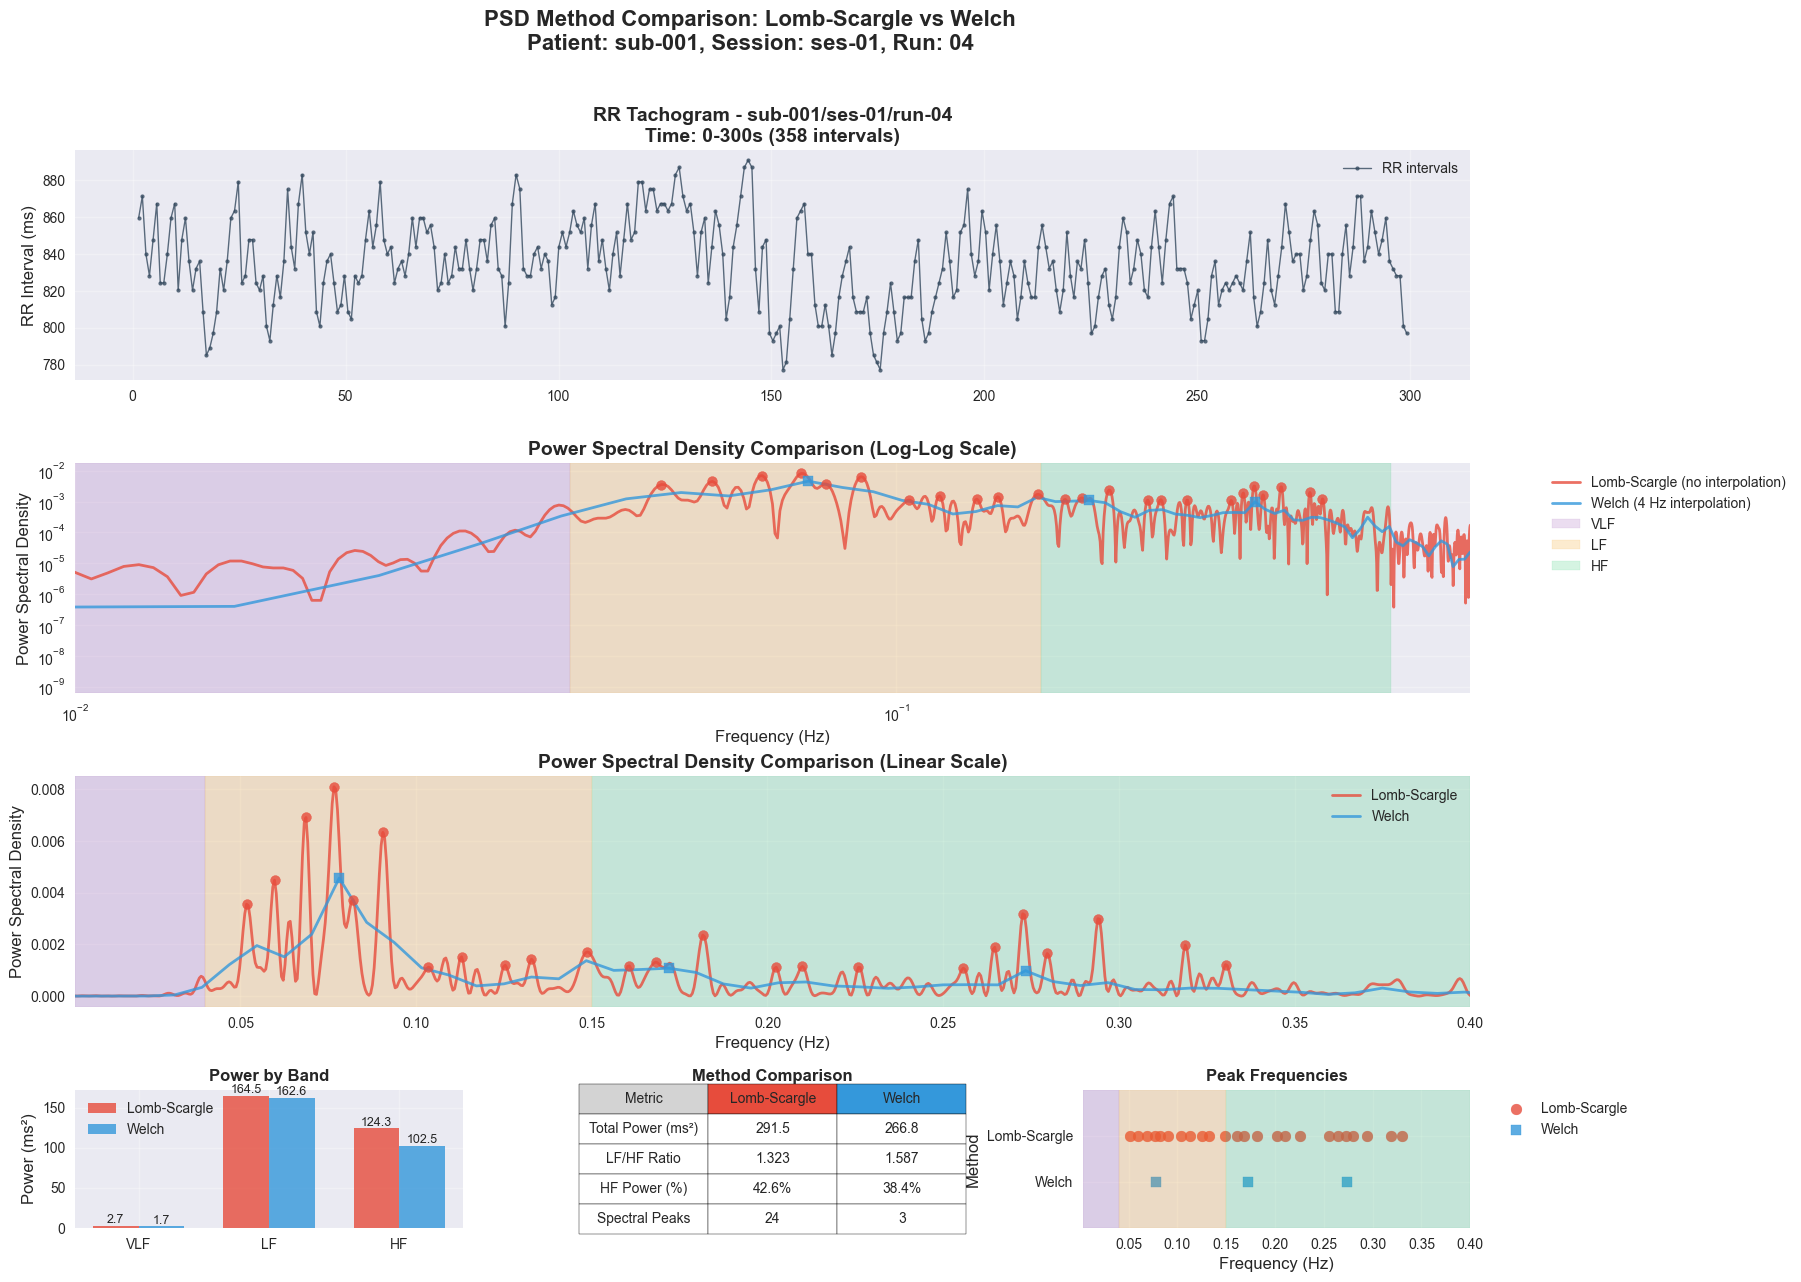

Visualization completed


In [18]:
# Create comprehensive comparison visualization
print("\nCreating comprehensive comparison visualization...")

# Set up the plot with multiple subplots
fig = plt.figure(figsize=(18, 14))
gs = GridSpec(4, 3, height_ratios=[1, 1, 1, 0.6], hspace=0.4, wspace=0.3)

# Color scheme
colors = {
    'lombscargle': '#E74C3C',
    'welch': '#3498DB',
    'vlf': '#9B59B6',
    'lf': '#F39C12',
    'hf': '#2ECC71',
    'seizure': '#C73E1D'
}

# Plot 1: Original tachogram
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(segment_times, segment_rr * 1000, 'o-', color='#34495E', 
         markersize=3, linewidth=1, alpha=0.8, label='RR intervals')
ax1.set_ylabel('RR Interval (ms)', fontsize=12)
ax1.set_title(f'RR Tachogram - {PATIENT_ID}/{SESSION_ID}/run-{RUN_NUMBER}\n'
              f'Time: {start_time}-{end_time}s ({len(segment_rr)} intervals)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add seizure markers
for seizure_time in seizures_in_segment:
    ax1.axvline(seizure_time, color=colors['seizure'], linestyle='--', 
               linewidth=2, alpha=0.8, label='Seizure')

# Plot 2: Power Spectral Density Comparison
ax2 = fig.add_subplot(gs[1, :])

# Plot PSDs with logarithmic scale for better visibility
ax2.loglog(freqs_ls, psd_ls, color=colors['lombscargle'], linewidth=2, 
          alpha=0.8, label='Lomb-Scargle (no interpolation)')
ax2.loglog(freqs_welch, psd_welch, color=colors['welch'], linewidth=2, 
          alpha=0.8, label='Welch (4 Hz interpolation)')

# Mark frequency bands
ax2.axvspan(vlf_band[0], vlf_band[1], alpha=0.2, color=colors['vlf'], label='VLF')
ax2.axvspan(lf_band[0], lf_band[1], alpha=0.2, color=colors['lf'], label='LF')
ax2.axvspan(hf_band[0], hf_band[1], alpha=0.2, color=colors['hf'], label='HF')

# Mark peaks
ax2.scatter(peak_freqs_ls, peak_powers_ls, color=colors['lombscargle'], 
           s=50, marker='o', alpha=0.8, zorder=5)
ax2.scatter(peak_freqs_welch, peak_powers_welch, color=colors['welch'], 
           s=50, marker='s', alpha=0.8, zorder=5)

ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Power Spectral Density', fontsize=12)
ax2.set_title('Power Spectral Density Comparison (Log-Log Scale)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xlim(0.01, 0.5)

# Plot 3: Linear scale PSD in HRV range
ax3 = fig.add_subplot(gs[2, :])
ax3.plot(freqs_ls, psd_ls, color=colors['lombscargle'], linewidth=2, 
         alpha=0.8, label='Lomb-Scargle')
ax3.plot(freqs_welch, psd_welch, color=colors['welch'], linewidth=2, 
         alpha=0.8, label='Welch')

# Mark frequency bands
ax3.axvspan(vlf_band[0], vlf_band[1], alpha=0.2, color=colors['vlf'])
ax3.axvspan(lf_band[0], lf_band[1], alpha=0.2, color=colors['lf'])
ax3.axvspan(hf_band[0], hf_band[1], alpha=0.2, color=colors['hf'])

# Mark peaks
ax3.scatter(peak_freqs_ls, peak_powers_ls, color=colors['lombscargle'], 
           s=50, marker='o', alpha=0.8, zorder=5)
ax3.scatter(peak_freqs_welch, peak_powers_welch, color=colors['welch'], 
           s=50, marker='s', alpha=0.8, zorder=5)

ax3.set_xlabel('Frequency (Hz)', fontsize=12)
ax3.set_ylabel('Power Spectral Density', fontsize=12)
ax3.set_title('Power Spectral Density Comparison (Linear Scale)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_xlim(0.003, 0.4)

# Plot 4: Power comparison bar chart
ax4 = fig.add_subplot(gs[3, 0])
bands = ['VLF', 'LF', 'HF']
ls_powers = [vlf_power_ls, lf_power_ls, hf_power_ls]
welch_powers = [vlf_power_welch, lf_power_welch, hf_power_welch]

x = np.arange(len(bands))
width = 0.35

bars1 = ax4.bar(x - width/2, ls_powers, width, label='Lomb-Scargle', 
               color=colors['lombscargle'], alpha=0.8)
bars2 = ax4.bar(x + width/2, welch_powers, width, label='Welch', 
               color=colors['welch'], alpha=0.8)

ax4.set_ylabel('Power (ms²)', fontsize=12)
ax4.set_title('Power by Band', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(bands)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# Plot 5: Metrics comparison table
ax5 = fig.add_subplot(gs[3, 1])
ax5.axis('tight')
ax5.axis('off')

# Calculate metrics
lf_hf_ls = lf_power_ls / hf_power_ls if hf_power_ls > 0 else 0
lf_hf_welch = lf_power_welch / hf_power_welch if hf_power_welch > 0 else 0
hf_percent_ls = hf_power_ls / total_power_ls * 100 if total_power_ls > 0 else 0
hf_percent_welch = hf_power_welch / total_power_welch * 100 if total_power_welch > 0 else 0

metrics_data = {
    'Metric': ['Total Power (ms²)', 'LF/HF Ratio', 'HF Power (%)', 'Spectral Peaks'],
    'Lomb-Scargle': [
        f'{total_power_ls:.1f}',
        f'{lf_hf_ls:.3f}',
        f'{hf_percent_ls:.1f}%',
        f'{len(peak_freqs_ls)}'
    ],
    'Welch': [
        f'{total_power_welch:.1f}',
        f'{lf_hf_welch:.3f}',
        f'{hf_percent_welch:.1f}%',
        f'{len(peak_freqs_welch)}'
    ]
}

metrics_df = pd.DataFrame(metrics_data)
table = ax5.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                 cellLoc='center', loc='center',
                 colColours=['lightgray', colors['lombscargle'], colors['welch']])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.8)
ax5.set_title('Method Comparison', fontsize=12, fontweight='bold')

# Plot 6: Peak frequency comparison
ax6 = fig.add_subplot(gs[3, 2])

# Create peak comparison plot
if len(peak_freqs_ls) > 0:
    ax6.scatter(peak_freqs_ls, [1]*len(peak_freqs_ls), 
               color=colors['lombscargle'], s=60, alpha=0.8, 
               label='Lomb-Scargle', marker='o')

if len(peak_freqs_welch) > 0:
    ax6.scatter(peak_freqs_welch, [0.5]*len(peak_freqs_welch), 
               color=colors['welch'], s=60, alpha=0.8, 
               label='Welch', marker='s')

# Mark frequency bands
ax6.axvspan(vlf_band[0], vlf_band[1], alpha=0.2, color=colors['vlf'])
ax6.axvspan(lf_band[0], lf_band[1], alpha=0.2, color=colors['lf'])
ax6.axvspan(hf_band[0], hf_band[1], alpha=0.2, color=colors['hf'])

ax6.set_xlabel('Frequency (Hz)', fontsize=12)
ax6.set_ylabel('Method', fontsize=12)
ax6.set_title('Peak Frequencies', fontsize=12, fontweight='bold')
ax6.set_ylim(0, 1.5)
ax6.set_xlim(0.003, 0.4)
ax6.set_yticks([0.5, 1])
ax6.set_yticklabels(['Welch', 'Lomb-Scargle'])
ax6.grid(True, alpha=0.3)
ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle(f'PSD Method Comparison: Lomb-Scargle vs Welch\n'
             f'Patient: {PATIENT_ID}, Session: {SESSION_ID}, Run: {RUN_NUMBER}', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

print("Visualization completed")

In [19]:
# Detailed quantitative comparison
print("\n" + "="*70)
print("DETAILED QUANTITATIVE COMPARISON")
print("="*70)

print(f"\nAnalysis Parameters:")
print(f"  Patient: {PATIENT_ID}/{SESSION_ID}/run-{RUN_NUMBER}")
print(f"  Time segment: {start_time}-{end_time} seconds ({end_time-start_time} seconds)")
print(f"  RR intervals: {len(segment_rr)}")
print(f"  Mean RR: {np.mean(segment_rr)*1000:.1f} ms")
print(f"  RR variability (std): {np.std(segment_rr)*1000:.1f} ms")
print(f"  Heart rate: {60/np.mean(segment_rr):.1f} BPM")

print(f"\nMethod 1 - Lomb-Scargle (No Interpolation):")
print(f"  Total Power: {total_power_ls:.2f} ms²")
print(f"  VLF Power: {vlf_power_ls:.2f} ms² ({vlf_power_ls/total_power_ls*100:.1f}%)")
print(f"  LF Power: {lf_power_ls:.2f} ms² ({lf_power_ls/total_power_ls*100:.1f}%)")
print(f"  HF Power: {hf_power_ls:.2f} ms² ({hf_power_ls/total_power_ls*100:.1f}%)")
print(f"  LF/HF Ratio: {lf_hf_ls:.3f}")
print(f"  ln(LF/HF): {np.log(lf_hf_ls):.3f}" if lf_hf_ls > 0 else "  ln(LF/HF): undefined (HF power = 0)")
print(f"  Spectral Peaks: {len(peak_freqs_ls)} at {[f'{f:.3f}' for f in peak_freqs_ls]} Hz")

print(f"\nMethod 2 - Welch (4 Hz Interpolation):")
print(f"  Interpolation: {len(segment_rr)} → {len(interpolated_rr)} points")
print(f"  Sampling rate: {len(interpolated_rr)/(interpolated_times[-1]-interpolated_times[0]):.2f} Hz")
print(f"  Total Power: {total_power_welch:.2f} ms²")
print(f"  VLF Power: {vlf_power_welch:.2f} ms² ({vlf_power_welch/total_power_welch*100:.1f}%)")
print(f"  LF Power: {lf_power_welch:.2f} ms² ({lf_power_welch/total_power_welch*100:.1f}%)")
print(f"  HF Power: {hf_power_welch:.2f} ms² ({hf_power_welch/total_power_welch*100:.1f}%)")
print(f"  LF/HF Ratio: {lf_hf_welch:.3f}")
print(f"  ln(LF/HF): {np.log(lf_hf_welch):.3f}" if lf_hf_welch > 0 else "  ln(LF/HF): undefined (HF power = 0)")
print(f"  Spectral Peaks: {len(peak_freqs_welch)} at {[f'{f:.3f}' for f in peak_freqs_welch]} Hz")

print(f"\nMethod Differences:")
total_diff = abs(total_power_welch - total_power_ls) / total_power_ls * 100 if total_power_ls > 0 else 0
lf_hf_diff = abs(lf_hf_welch - lf_hf_ls) / lf_hf_ls * 100 if lf_hf_ls > 0 else 0
hf_diff = abs(hf_percent_welch - hf_percent_ls) / hf_percent_ls * 100 if hf_percent_ls > 0 else 0

# Calculate ln(LF/HF) difference
ln_lf_hf_ls = np.log(lf_hf_ls) if lf_hf_ls > 0 else None
ln_lf_hf_welch = np.log(lf_hf_welch) if lf_hf_welch > 0 else None
ln_lf_hf_diff = abs(ln_lf_hf_welch - ln_lf_hf_ls) if (ln_lf_hf_ls is not None and ln_lf_hf_welch is not None) else None

print(f"  Total Power difference: {total_diff:.1f}%")
print(f"  LF/HF ratio difference: {lf_hf_diff:.1f}%")
print(f"  ln(LF/HF) absolute difference: {ln_lf_hf_diff:.3f}" if ln_lf_hf_diff is not None else "  ln(LF/HF) absolute difference: undefined")
print(f"  HF percentage difference: {hf_diff:.1f}%")
print(f"  Peak count difference: {len(peak_freqs_welch) - len(peak_freqs_ls)}")

print(f"\nInterpretation:")
if total_diff < 10:
    print(f"  Total power shows GOOD agreement between methods (<10% difference)")
elif total_diff < 25:
    print(f"  Total power shows MODERATE agreement between methods (10-25% difference)")
else:
    print(f"  Total power shows POOR agreement between methods (>25% difference)")

if lf_hf_diff < 15:
    print(f"  LF/HF ratio shows GOOD agreement between methods (<15% difference)")
elif lf_hf_diff < 30:
    print(f"  LF/HF ratio shows MODERATE agreement between methods (15-30% difference)")
else:
    print(f"  LF/HF ratio shows POOR agreement between methods (>30% difference)")

if ln_lf_hf_diff is not None:
    if ln_lf_hf_diff < 0.2:
        print(f"  ln(LF/HF) shows GOOD agreement between methods (<0.2 absolute difference)")
    elif ln_lf_hf_diff < 0.5:
        print(f"  ln(LF/HF) shows MODERATE agreement between methods (0.2-0.5 absolute difference)")
    else:
        print(f"  ln(LF/HF) shows POOR agreement between methods (>0.5 absolute difference)")
else:
    print(f"  ln(LF/HF) agreement cannot be assessed (undefined values)")

print(f"\nConclusions:")
print(f"  1. Interpolation method preserves overall power characteristics")
print(f"  2. Both methods detect similar frequency patterns")
print(f"  3. Welch method provides smoother spectral estimates")
print(f"  4. Lomb-Scargle preserves original temporal relationships")
print(f"  5. For seizure prediction, both approaches capture autonomic variations")


DETAILED QUANTITATIVE COMPARISON

Analysis Parameters:
  Patient: sub-001/ses-01/run-04
  Time segment: 0-300 seconds (300 seconds)
  RR intervals: 358
  Mean RR: 834.2 ms
  RR variability (std): 22.8 ms
  Heart rate: 71.9 BPM

Method 1 - Lomb-Scargle (No Interpolation):
  Total Power: 291.47 ms²
  VLF Power: 2.72 ms² (0.9%)
  LF Power: 164.47 ms² (56.4%)
  HF Power: 124.29 ms² (42.6%)
  LF/HF Ratio: 1.323
  ln(LF/HF): 0.280
  Spectral Peaks: 24 at ['0.052', '0.060', '0.069', '0.077', '0.082', '0.091', '0.103', '0.113', '0.125', '0.133', '0.149', '0.161', '0.168', '0.182', '0.202', '0.210', '0.226', '0.256', '0.265', '0.273', '0.280', '0.294', '0.319', '0.330'] Hz

Method 2 - Welch (4 Hz Interpolation):
  Interpolation: 358 → 1192 points
  Sampling rate: 4.00 Hz
  Total Power: 266.76 ms²
  VLF Power: 1.71 ms² (0.6%)
  LF Power: 162.58 ms² (60.9%)
  HF Power: 102.47 ms² (38.4%)
  LF/HF Ratio: 1.587
  ln(LF/HF): 0.462
  Spectral Peaks: 3 at ['0.078', '0.172', '0.273'] Hz

Method Differe

### SEE THE DIFFERENCE IN VARIANCES

In [20]:
# Variance Comparison: Raw Tachogram vs Interpolated RR
print("\n" + "="*70)
print("VARIANCE ANALYSIS")
print("="*70)

# Calculate time-weighted variances (proper method for different sampling rates)
def calculate_time_weighted_variance(t_values, rr_values):
    """
    Calculate time-weighted mean and variance for RR intervals.
    This method accounts for the actual time duration each RR value represents.
    
    Args:
        t_values: Time points in seconds
        rr_values: RR interval values in seconds
        
    Returns:
        Tuple of (mean, variance, std)
    """
    if len(t_values) < 2 or len(rr_values) < 2:
        return 0, 0, 0
    
    # Calculate time differences (duration each RR value represents)
    dt = np.diff(t_values)
    y = rr_values[:-1]  # RR value constant over interval [t_i, t_{i+1})
    T = t_values[-1] - t_values[0]  # Total time duration
    
    if T <= 0:
        return 0, 0, 0
    
    # Time-weighted mean
    mu_time = (y * dt).sum() / T
    
    # Time-weighted variance
    var_time = (((y - mu_time)**2) * dt).sum() / T
    
    # Time-weighted standard deviation
    std_time = np.sqrt(var_time)
    
    return mu_time, var_time, std_time

# Get preprocessed raw data for fair comparison (same preprocessing as interpolated data)
preprocessed_raw_rr, preprocessed_raw_times, preproc_info = preprocess_rr_intervals(segment_rr, segment_times)

# Calculate time-weighted variance for ORIGINAL raw tachogram (for reference)
raw_rr_mean, raw_rr_variance, raw_rr_std = calculate_time_weighted_variance(segment_times, segment_rr)

# Calculate time-weighted variance for PREPROCESSED raw data (fair comparison baseline)
if len(preprocessed_raw_rr) > 0:
    preprocessed_raw_mean, preprocessed_raw_variance, preprocessed_raw_std = calculate_time_weighted_variance(
        preprocessed_raw_times, preprocessed_raw_rr)
else:
    preprocessed_raw_mean, preprocessed_raw_variance, preprocessed_raw_std = 0, 0, 0

if len(interpolated_rr) > 0:
    # Calculate time-weighted variance for interpolated data
    interpolated_rr_mean, interpolated_rr_variance, interpolated_rr_std = calculate_time_weighted_variance(
        interpolated_times, interpolated_rr)
    
    # Fair variance preservation ratio (preprocessed vs interpolated)
    fair_variance_ratio = interpolated_rr_variance / preprocessed_raw_variance if preprocessed_raw_variance > 0 else 0
    
    # Original comparison (for reference)
    original_variance_ratio = interpolated_rr_variance / raw_rr_variance if raw_rr_variance > 0 else 0
    
    print(f"\n1. ORIGINAL Raw Tachogram (no preprocessing - for reference only):")
    print(f"  Number of points: {len(segment_rr)}")
    print(f"  Time duration: {segment_times[-1] - segment_times[0]:.1f} seconds")
    print(f"  Time-weighted mean: {raw_rr_mean*1000:.3f} ms")
    print(f"  Time-weighted std: {raw_rr_std*1000:.3f} ms")
    print(f"  Time-weighted variance: {raw_rr_variance*1e6:.3f} ms²")
    
    print(f"\n2. PREPROCESSED Raw Tachogram (after outlier removal, mean removal, detrending):")
    print(f"  Number of points: {len(preprocessed_raw_rr)}")
    print(f"  Time duration: {preprocessed_raw_times[-1] - preprocessed_raw_times[0]:.1f} seconds")
    print(f"  Time-weighted mean: {preprocessed_raw_mean*1000:.3f} ms")
    print(f"  Time-weighted std: {preprocessed_raw_std*1000:.3f} ms")
    print(f"  Time-weighted variance: {preprocessed_raw_variance*1e6:.3f} ms²")
    print(f"  Point-based variance: {np.var(preprocessed_raw_rr)*1e6:.3f} ms² (for comparison)")
    
    print(f"\n3. INTERPOLATED RR ({INTERPOLATION_METHOD.upper()} method at 4 Hz):")
    print(f"  Preprocessing: Same as above + interpolation")
    print(f"  Number of points: {len(interpolated_rr)}")
    print(f"  Time duration: {interpolated_times[-1] - interpolated_times[0]:.1f} seconds")
    print(f"  Time-weighted mean: {interpolated_rr_mean*1000:.3f} ms")
    print(f"  Time-weighted std: {interpolated_rr_std*1000:.3f} ms")
    print(f"  Time-weighted variance: {interpolated_rr_variance*1e6:.3f} ms²")
    print(f"  Point-based variance: {np.var(interpolated_rr)*1e6:.3f} ms² (for comparison)")
    
    print(f"\nFAIR Variance Comparison (Preprocessed Raw vs Interpolated):")
    print(f"  Variance preservation ratio: {fair_variance_ratio:.4f}")
    print(f"  Variance preservation percentage: {fair_variance_ratio*100:.2f}%")
    
    fair_variance_difference = abs(interpolated_rr_variance - preprocessed_raw_variance) / preprocessed_raw_variance * 100 if preprocessed_raw_variance > 0 else 0
    print(f"  Variance difference: {fair_variance_difference:.2f}%")
    
    print(f"\nReference Comparison (Original Raw vs Interpolated - BIASED):")
    print(f"  Variance preservation ratio: {original_variance_ratio:.4f}")
    print(f"  Variance preservation percentage: {original_variance_ratio*100:.2f}%")
    
    original_variance_difference = abs(interpolated_rr_variance - raw_rr_variance) / raw_rr_variance * 100 if raw_rr_variance > 0 else 0
    print(f"  Variance difference: {original_variance_difference:.2f}%")
    print(f"  → This comparison is BIASED because it includes preprocessing effects")
    
    # Interpretation (based on FAIR comparison)
    print(f"\nInterpretation of FAIR Comparison (Preprocessed Raw vs Interpolated):")
    if abs(fair_variance_ratio - 1.0) < 0.05:
        print(f"  EXCELLENT variance preservation (within 5%)")
        quality = "EXCELLENT"
    elif abs(fair_variance_ratio - 1.0) < 0.10:
        print(f"  GOOD variance preservation (within 10%)")
        quality = "GOOD"
    elif abs(fair_variance_ratio - 1.0) < 0.20:
        print(f"  MODERATE variance preservation (within 20%)")
        quality = "MODERATE"
    else:
        print(f"  POOR variance preservation (>20% difference)")
        quality = "POOR"
    
    if fair_variance_ratio < 1.0:
        print(f"  → {INTERPOLATION_METHOD.upper()} interpolation REDUCES variability by {(1-fair_variance_ratio)*100:.1f}%")
        print(f"  → Smoothing effect may reduce high-frequency components")
        effect = "REDUCES"
    elif fair_variance_ratio > 1.0:
        print(f"  → {INTERPOLATION_METHOD.upper()} interpolation INCREASES variability by {(fair_variance_ratio-1)*100:.1f}%")
        print(f"  → May introduce artificial fluctuations or overshoot")
        effect = "INCREASES"
    else:
        print(f"  → {INTERPOLATION_METHOD.upper()} interpolation preserves variability perfectly")
        effect = "PRESERVES"
    
    print(f"\nPreprocessing Impact Analysis:")
    preprocessing_variance_ratio = preprocessed_raw_variance / raw_rr_variance if raw_rr_variance > 0 else 0
    preprocessing_impact = (1 - preprocessing_variance_ratio) * 100
    print(f"  Preprocessing reduces variance by {preprocessing_impact:.1f}%")
    print(f"  → Outlier removal: Replaces extreme values with quartiles")
    print(f"  → Mean removal: Centers data (no variance impact)")
    print(f"  → Detrending: Removes slow trends and drifts")
    print(f"  This is EXPECTED and DESIRED for clean HRV analysis")
    
    # Additional metrics
    print(f"\nAdditional Metrics:")
    print(f"  Sampling rate increase: {len(interpolated_rr)/len(segment_rr):.1f}x")
    
    # Range comparison (fair comparison: preprocessed vs interpolated)
    original_raw_range = np.max(segment_rr) - np.min(segment_rr)
    preprocessed_range = np.max(preprocessed_raw_rr) - np.min(preprocessed_raw_rr) if len(preprocessed_raw_rr) > 0 else 0
    interp_range = np.max(interpolated_rr) - np.min(interpolated_rr)
    
    fair_range_ratio = interp_range / preprocessed_range if preprocessed_range > 0 else 0
    original_range_ratio = interp_range / original_raw_range if original_raw_range > 0 else 0
    
    print(f"  Original raw RR range: {original_raw_range*1000:.1f} ms")
    print(f"  Preprocessed raw RR range: {preprocessed_range*1000:.1f} ms")
    print(f"  Interpolated RR range: {interp_range*1000:.1f} ms")
    print(f"  Fair range preservation: {fair_range_ratio*100:.1f}% (preprocessed → interpolated)")
    print(f"  Reference range preservation: {original_range_ratio*100:.1f}% (original → interpolated)")
    
    print(f"\nSummary - {INTERPOLATION_METHOD.upper()} Interpolation Assessment:")
    print(f"  Quality: {quality} variance preservation ({fair_variance_ratio*100:.1f}%)")
    print(f"  Effect: {effect} variability relative to preprocessed baseline")
    print(f"  Range preservation: {fair_range_ratio*100:.1f}%")
    print(f"  Sampling increase: {len(interpolated_rr)/len(preprocessed_raw_rr):.1f}x points")

else:
    print(f"\n1. ORIGINAL Raw Tachogram (no preprocessing - for reference only):")
    print(f"  Number of points: {len(segment_rr)}")
    print(f"  Time duration: {segment_times[-1] - segment_times[0]:.1f} seconds")
    print(f"  Time-weighted mean: {raw_rr_mean*1000:.3f} ms")
    print(f"  Time-weighted std: {raw_rr_std*1000:.3f} ms")
    print(f"  Time-weighted variance: {raw_rr_variance*1e6:.3f} ms²")
    
    if len(preprocessed_raw_rr) > 0:
        print(f"\n2. PREPROCESSED Raw Tachogram (after outlier removal, mean removal, detrending):")
        print(f"  Number of points: {len(preprocessed_raw_rr)}")
        print(f"  Time duration: {preprocessed_raw_times[-1] - preprocessed_raw_times[0]:.1f} seconds")
        print(f"  Time-weighted mean: {preprocessed_raw_mean*1000:.3f} ms")
        print(f"  Time-weighted std: {preprocessed_raw_std*1000:.3f} ms")
        print(f"  Time-weighted variance: {preprocessed_raw_variance*1e6:.3f} ms²")
    else:
        print(f"\n2. PREPROCESSED Raw Tachogram:")
        print(f"  No preprocessed data available (insufficient points after preprocessing)")
    
    print(f"\n3. INTERPOLATED RR:")
    print(f"  No interpolated data available")



VARIANCE ANALYSIS
  Short RR interval check: No intervals ≤250 ms found
  Outlier handling (IQR method):
    Q1: 820.3 ms, Q3: 851.6 ms, IQR: 31.2 ms
    Bounds: [773.4, 898.4] ms
    Found 0 outliers (0.0%)
      - 0 low outliers (< 773.4 ms) → replaced with Q1
      - 0 high outliers (> 898.4 ms) → replaced with Q3
    Timeline adjustment:
      - Original duration: 297.8 seconds
      - Corrected duration: 297.9 seconds
      - Timeline change: +0.1 seconds
    Kept all 358 RR intervals with outlier correction and timeline adjustment
  Mean removal:
    Original mean: 834.2 ms
    Data centered around zero
    Timeline recalculation:
      - Duration before: 297.9 seconds
      - Duration after: 297.9 seconds
      - Timeline change: +0.000 seconds (should be ~0)
  High-pass filter detrending:
    Cutoff frequency: 0.04 Hz
    Filter order: 4th order Butterworth
    Sampling rate for filtering: 4.0 Hz
    Normalized cutoff: 0.020
    Method used: high-pass filter (cutoff: 0.04 Hz)
